In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *
from scripts.sm_utils import *

In [2]:
config = load_config()
od = ''

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

## 250317 merge bams expands

In [12]:
df = pd.read_csv('data_kinnex_pre_release.index.csv', sep=',')
df['sample_rep'] = df['sample_id']+'_'+(df.sort_values(by=['sample_id']).groupby(['sample_id']).cumcount()+1).astype(str)

# if there should be a 1:1 relationship
def get_df_val(df, col1, col_dict):
    temp = df.copy(deep=True)

    for key, item in col_dict.items():
        temp = temp.loc[temp[key] == item]

    val = temp[col1].unique()
    assert len(val) == 1
    return val[0]

# if you're doing a merge / gather
def get_df_vals(df, col1, col_dict):
    temp = df.copy(deep=True)

    for key, item in col_dict.items():
        temp = temp.loc[temp[key] == item]

    val = temp[col1].unique()
    return val

In [13]:
wc = {'sample_id':'HG00423'}
# lambda wc:
expand(get_df_vals(df, 'sample_rep',
                   {'sample_id':wc['sample_id']})

array(['HG00423_1', 'HG00423_2'], dtype=object)

# config prasing

In [29]:
df = pd.read_csv('data_kinnex_pre_release.index.csv', sep=',')
df['sample_rep'] = df['sample_id']+'_'+(df.sort_values(by=['sample_id']).groupby(['sample_id']).cumcount()+1).astype(str)

In [37]:
df.loc[df.sample_id=='HG00423']

,path,sample_id,total_reads,filename,title,study,bioproject_accession,accession,biosample_accession,library_id,...,size_selection,design_description,polymerase_version,seq_plate_chemistry_version,pool,ntsm_score,similarity,check-flnc reads,generator_contact,sample_rep
0,s3://human-pangenomics/working/HPRC/HG00423/ra...,HG00423,5805662,HG00423.lymph.m84046_240713_051553_s2.flnc.bam,flnc bams of PacBio HiFi iso-seq sequencing of...,SRP305758,PRJNA701308,NaN,NaN,HG00423.lymph.m84046_240713_051553_s2,...,NaN,PacBio HiFi iso-seq sequencing of cDNA kinnex ...,P1,C1,HPRC_Pool001.KN,0.183349,1,True,iviolich@ucsc.edu,HG00423_1
1,s3://human-pangenomics/working/HPRC/HG00423/ra...,HG00423,6354937,HG00423.lymph.m84046_240722_012946_s4.flnc.bam,flnc bams of PacBio HiFi iso-seq sequencing of...,SRP305758,PRJNA701308,NaN,NaN,HG00423.lymph.m84046_240722_012946_s4,...,NaN,PacBio HiFi iso-seq sequencing of cDNA kinnex ...,P1,C1,HPRC_Pool001.KN,0.177367,1,True,iviolich@ucsc.edu,HG00423_2


In [38]:
def get_df_val(df, col1, col_dict):
    temp = df.copy(deep=True)

    for key, item in col_dict.items():
        temp = temp.loc[temp[key] == item]

    val = temp[col1].unique()
    assert len(val) == 1
    return val[0]

wc = {'sample_rep':'HG00423_2'}
get_df_val(df, 'path',
                             {'sample_rep':wc['sample_rep']})


's3://human-pangenomics/working/HPRC/HG00423/raw_data/PacBio_Kinnex/HG00423.lymph.m84046_240722_012946_s4.flnc.bam'

## Overlap w/ our samples

In [21]:
meta = load_meta()
meta = meta.merge(df[['sample_id']], 
                  how='left',
                  left_on='cell_line_id',
                  right_on='sample_id')

In [22]:
meta = meta.merge(df[['sample_id']], 
                  how='left',
                  left_on='hapmap_DNA_ID',
                  right_on='sample_id')

In [23]:
meta['in_hprc_kinnex'] = meta.sample_id_x.notnull()|meta.sample_id_y.notnull()

In [25]:
temp = meta.loc[meta.in_hprc_kinnex==True]
temp = temp[['cell_line_id', 'population']].groupby('population').nunique().reset_index().rename({'cell_line_id':'n_samples'}, axis=1)

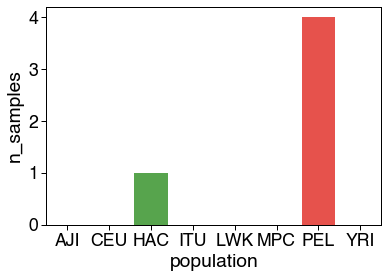

In [27]:
init_plot_settings(aspect='rectangle')
c_dict, order = get_population_colors()
ax = sns.barplot(temp, y='n_samples', 
                 x='population',
                 order=order,
                 palette=c_dict)

In [28]:
len(df.sample_id.unique())

202